In [1]:
import sqlalchemy
from sqlalchemy import create_engine
import pymysql
import os
import pandas as pd
import matplotlib.pyplot as plt
from finta import TA

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import ray.rllib.agents.ppo as ppo
import tensortrade.env.default as default
from gym.spaces import Discrete
from ray import tune
from ray.tune.registry import register_env
from symfit import parameters, variables, sin, cos, Fit
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.env.generic import Renderer
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.exchanges import ExchangeOptions
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.orders import proportion_order
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import PBR

import tensortrade.stochastic as sp

import tensortrade.env.default.rewards as rewards
from tensortrade.env.default.actions import ManagedRiskOrders
from tensortrade.env.default.rewards import SimpleProfit

In [2]:
def get_data():
    x = np.arange(0, 2*np.pi, 2*np.pi / 390)
    y = 50*np.sin(3*x) + 100
    data = pd.DataFrame(data=y, columns=["open"])
    data["date"] = pd.date_range(start='03/01/2021', freq='MIN', periods=390)
    data["high"] = data["open"]
    data["low"] = data["open"]
    data["close"] = data["open"]
    data["volume"] = 10
    data = data[["date", "open", "high", "low", "close", "volume"]]
    return data

<AxesSubplot:xlabel='date'>

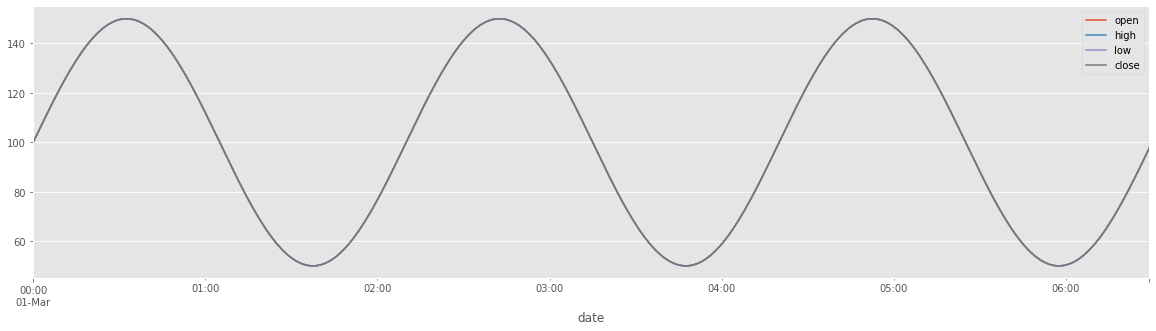

In [3]:
data = get_data()
data.plot(x="date", y=["open", "high", "low", "close"], figsize=(20,5))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    390 non-null    datetime64[ns]
 1   open    390 non-null    float64       
 2   high    390 non-null    float64       
 3   low     390 non-null    float64       
 4   close   390 non-null    float64       
 5   volume  390 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 18.4 KB


In [5]:
USD = Instrument("USD", 2, "U.S. Dollar")
TSLA = Instrument("TSLA", 8, "Tesla, Inc.")

def create_env(config):

    # Sine wave
    data = get_data()
    
    p = Stream.source(list(data["close"]), dtype="float").rename("USD-TSLA")
 
    simulated_exchange = Exchange(
        "simulated_exchange", 
        service=execute_order, 
        options=ExchangeOptions(commission=0.03)
    )( p )

    cash = Wallet(simulated_exchange, 10000 * USD)
    asset = Wallet(simulated_exchange, 0 * TSLA)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"),
        Stream.source(list(data["volume"]), dtype="float").rename("volume"),
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    # A simple reward scheme that rewards the agent for incremental increases in net worth
    reward_scheme = SimpleProfit()

    # A discrete action scheme that determines actions based on managing risk
    action_scheme = ManagedRiskOrders()

    
    renderer_feed = DataFeed([
        Stream.source(list(data["date"]), dtype="datetime64").rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"),
        Stream.source(list(data["volume"]), dtype="float").rename("volume"),
    ])


    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=25,
        max_allowed_loss=0.6
    )
    return environment


register_env("TradingEnv", create_env)

In [6]:
analysis = tune.run(
    "PPO",
    stop={
      "info/num_steps_trained": 20000,
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1, #os.cpu_count() - 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2022-04-25 23:24:12,183	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,PENDING,


2022-04-25 23:24:22,709	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=15196) 2022-04-25 23:24:27,852	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=15196) 2022-04-25 23:24:27,852	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


 pid=15196) 2022-04-25 23:24:36,767	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


 pid=15196) 2022-04-25 23:25:13,236	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=15196) 2022-04-25 23:25:13,236	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Trial name,status,loc
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196


Result for PPO_TradingEnv_fbfd5_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-25_23-25-47
  done: false
  episode_len_mean: 81.9375
  episode_media: {}
  episode_reward_max: -0.9031628384630225
  episode_reward_mean: -0.9186670096432284
  episode_reward_min: -0.9504970404521312
  episodes_this_iter: 48
  episodes_total: 48
  experiment_id: 7bcf3ec5502f46eaa94a2e852dc9e4d0
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 7.999999979801942e-06
          entropy: 5.194768905639648
          entropy_coeff: 0.009999999776482582
          kl: 0.0037225622218102217
          policy_loss: -0.025343846529722214
          total_loss: 0.2577734589576721
          vf_explained_var: 0.05293448641896248
          vf_loss: 0.6686409115791321
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iteration

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,1,71.0753,4000,-0.918667,-0.903163,-0.950497,81.9375


Result for PPO_TradingEnv_fbfd5_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-04-25_23-26-57
  done: false
  episode_len_mean: 81.5
  episode_media: {}
  episode_reward_max: -0.9031628384630225
  episode_reward_mean: -0.9183715117294505
  episode_reward_min: -0.9517906173499715
  episodes_this_iter: 50
  episodes_total: 98
  experiment_id: 7bcf3ec5502f46eaa94a2e852dc9e4d0
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 7.999999979801942e-06
          entropy: 5.175343990325928
          entropy_coeff: 0.009999999776482582
          kl: 0.0069223628379404545
          policy_loss: -0.037356700748205185
          total_loss: 0.12100350111722946
          vf_explained_var: 0.15409007668495178
          vf_loss: 0.41884276270866394
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_step

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,2,141.072,8000,-0.918372,-0.903163,-0.951791,81.5


Result for PPO_TradingEnv_fbfd5_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-04-25_23-28-05
  done: false
  episode_len_mean: 80.45
  episode_media: {}
  episode_reward_max: -0.9034505518006318
  episode_reward_mean: -0.9187702281674055
  episode_reward_min: -0.9517906173499715
  episodes_this_iter: 50
  episodes_total: 148
  experiment_id: 7bcf3ec5502f46eaa94a2e852dc9e4d0
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 7.999999979801942e-06
          entropy: 5.139645576477051
          entropy_coeff: 0.009999999776482582
          kl: 0.01038003247231245
          policy_loss: -0.049467723816633224
          total_loss: 0.06497621536254883
          vf_explained_var: 0.2540734112262726
          vf_loss: 0.32960474491119385
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,3,208.874,12000,-0.91877,-0.903451,-0.951791,80.45


Result for PPO_TradingEnv_fbfd5_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-04-25_23-29-13
  done: false
  episode_len_mean: 79.48
  episode_media: {}
  episode_reward_max: -0.9034505518006318
  episode_reward_mean: -0.9191323137301574
  episode_reward_min: -0.9489848899074944
  episodes_this_iter: 50
  episodes_total: 198
  experiment_id: 7bcf3ec5502f46eaa94a2e852dc9e4d0
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 7.999999979801942e-06
          entropy: 5.080766677856445
          entropy_coeff: 0.009999999776482582
          kl: 0.012837646529078484
          policy_loss: -0.0555502325296402
          total_loss: 0.04053081199526787
          vf_explained_var: 0.2820185124874115
          vf_loss: 0.291209876537323
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_step

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,RUNNING,127.0.0.1:15196,4,276.401,16000,-0.919132,-0.903451,-0.948985,79.48


Result for PPO_TradingEnv_fbfd5_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-04-25_23-30-28
  done: true
  episode_len_mean: 79.23
  episode_media: {}
  episode_reward_max: -0.9040254732132232
  episode_reward_mean: -0.9213271755365239
  episode_reward_min: -0.9525165706369862
  episodes_this_iter: 51
  episodes_total: 249
  experiment_id: 7bcf3ec5502f46eaa94a2e852dc9e4d0
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 7.999999979801942e-06
          entropy: 5.002301216125488
          entropy_coeff: 0.009999999776482582
          kl: 0.013553493656218052
          policy_loss: -0.05589212104678154
          total_loss: 0.027095334604382515
          vf_explained_var: 0.36502569913864136
          vf_loss: 0.2633102238178253
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_fbfd5_00000,TERMINATED,127.0.0.1:15196,5,351.507,20000,-0.921327,-0.904025,-0.952517,79.23


2022-04-25 23:30:31,009	INFO tune.py:626 -- Total run time: 368.54 seconds (368.35 seconds for the tuning loop).


In [7]:
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(metric="episode_reward_mean", mode="max"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2022-04-25 23:30:31,134	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2022-04-25 23:30:31,136	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-25 23:30:40,061	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-04-25 23:30:42,520	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\PPO\PPO_TradingEnv_fbfd5_00000_0_2022-04-25_23-24-22\checkpoint_000005\checkpoint-5
2022-04-25 23:30:42,522	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': 0, '_time_total': 351.50720477104187, '_episodes_total': 249}


In [8]:
env = create_env({
    "window_size": 25
})


episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

2022-04-25 23:30:42,570	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…